In [ ]:
import numpy as np
from scipy.stats import mode
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
import pandas as pd
import random


# 1. Train-Test-Split
def train_test_split(df, test_size):

    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df


# 2. Distinguish categorical and continuous features
def determine_type_of_feature(df):

    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")

    return feature_types


# 3. Accuracy
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()

    return accuracy

## Decision tree

In [ ]:
# 1.1 Data pure?
def check_purity(data):

    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False


# 1.2 Classify
def classify_data(data):

    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification


# 1.3 Potential splits?
def get_potential_splits(data):

    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):  # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)

        potential_splits[column_index] = unique_values

    return potential_splits


# 1.4 Lowest Overall Entropy?
def calculate_entropy(data):

    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy

def calculate_misclassification(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    p = counts / counts.sum()
    misclassification = 1 - np.max(p)
    return misclassification

def calculate_gini(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    probabilities = counts / counts.sum()
    gini = 1 - np.sum(probabilities ** 2)
    return gini

def calculate_overall_metric(data_below, data_above, metric='misclassification'):
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n
    if metric == 'entropy':
        overall_metric = (p_data_below * calculate_entropy(data_below) +
                          p_data_above * calculate_entropy(data_above))
    elif metric == 'misclassification':
        overall_metric = (p_data_below * calculate_misclassification(data_below) +
                          p_data_above * calculate_misclassification(data_above))
    elif metric == 'gini':
        overall_metric = (p_data_below * calculate_gini(data_below) +
                          p_data_above * calculate_gini(data_above))
    else:
        raise ValueError("Invalid metric specified. Choose 'entropy', 'misclassification', or 'gini'.")
    return overall_metric

def determine_best_split(data, potential_splits, metric='misclassification'):
    best_split_column = None
    best_split_value = None
    min_overall_metric = float('inf')

    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)

            if len(data_below) == 0 or len(data_above) == 0:
                continue  # Skip this split if it results in empty arrays

            current_overall_metric = calculate_overall_metric(data_below, data_above, metric)

            if current_overall_metric <= min_overall_metric:
                min_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value

    return best_split_column, best_split_value


'''
def calculate_overall_entropy(data_below, data_above):

    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below)
                      + p_data_above * calculate_entropy(data_above))

    return overall_entropy


def determine_best_split(data, potential_splits):

    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value

    return best_split_column, best_split_value
'''

# 1.5 Split data
def split_data(data, split_column, split_value):

    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]

    # feature is categorical
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]

    return data_below, data_above


# 2. Decision Tree Algorithm
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):

    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df


    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)

        return classification


    # recursive part
    else:
        counter += 1

        # helper functions
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification

        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)

        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)

        # instantiate sub-tree
        sub_tree = {question: []}

        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)

        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree


# 3. Make predictions
# 3.1 One example
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)


# 3.2 All examples of the test data
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline

import random
from pprint import pprint

## Load the dataset

In [ ]:
df = pd.read_csv("/content/winequality-red.csv")
df["label"] = df.quality
df = df.drop("quality", axis=1)

column_names = []
for column in df.columns:
    name = column.replace(" ", "_")
    column_names.append(name)
df.columns = column_names

df.head()

In [ ]:
df = pd.read_csv("/content/hd_blobs (1).csv")
df["label"] = df["class"]
df = df.drop("class", axis=1)

column_names = []
for column in df.columns:
    name = column.replace(" ", "_")
    column_names.append(name)
df.columns = column_names

df.head()

,Unnamed:_0,0,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,label
0,0,-0.292646,0.010606,0.944840,1.201303,-0.945788,-0.160879,-1.083789,0.942056,0.165573,...,-0.953488,-0.053074,0.177118,0.790341,0.300354,-0.089351,0.209604,1.085910,0.469771,0
1,1,-0.512243,0.317387,-0.645673,-0.688082,-0.041672,0.571720,0.100466,0.309708,0.091889,...,0.329303,0.095571,-0.505032,-0.664487,-0.018459,-0.035452,-0.270935,0.214299,-0.162481,0
2,2,0.315504,0.677749,0.378154,-0.925553,0.333851,0.872945,0.832643,-0.516569,0.314701,...,0.137061,-0.490458,-0.482551,-0.517650,0.343848,1.357827,-0.006813,-0.248016,0.509620,0
3,3,-1.070802,0.972266,-0.802059,-0.089209,0.937171,0.309318,-1.398515,-0.712364,0.994158,...,-0.582183,1.162093,0.668342,-0.529424,0.072095,-0.296528,1.381026,-0.061682,-0.632329,0
4,4,1.213117,2.788031,1.700591,0.705456,2.277730,1.436718,2.031282,1.179836,0.504633,...,2.166478,1.631993,2.117681,1.928434,1.736845,2.031839,3.911921,2.521131,2.148881,1


<Axes: >

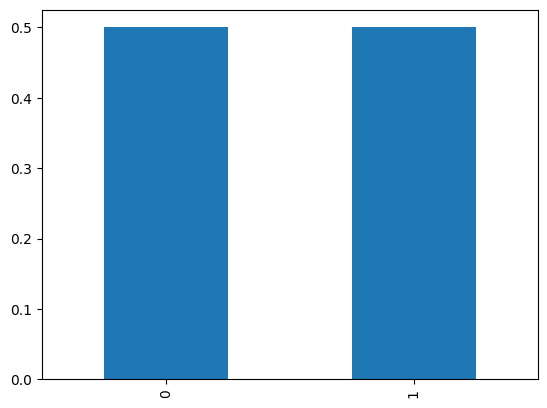

In [ ]:
blobs = df.label.value_counts(normalize=True)
blobs = blobs.sort_index()
blobs.plot(kind="bar")

In [ ]:
def transform_label(value):
    if value == 0:
        return "bad"
    else:
        return "good"

df["label"] = df.label.apply(transform_label)

bad     0.5
good    0.5
Name: label, dtype: float64

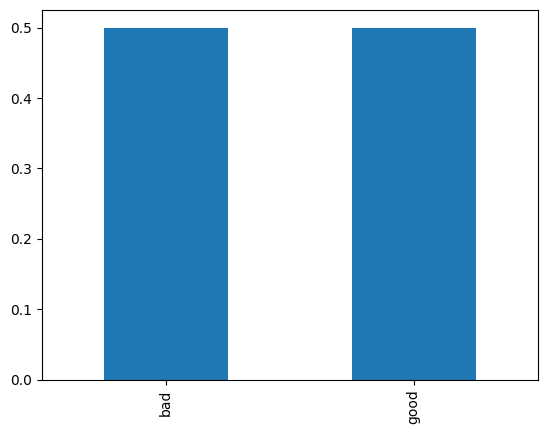

In [ ]:
blobs = df.label.value_counts(normalize=True)
blobs[["bad", "good"]].plot(kind="bar")
blobs

In [ ]:
wine_quality = df.label.value_counts(normalize=True)
wine_quality = wine_quality.sort_index()
wine_quality.plot(kind="bar")

In [ ]:
def transform_label(value):
    if value <= 5:
        return "bad"
    else:
        return "good"

df["label"] = df.label.apply(transform_label)

good    0.534709
bad     0.465291
Name: label, dtype: float64

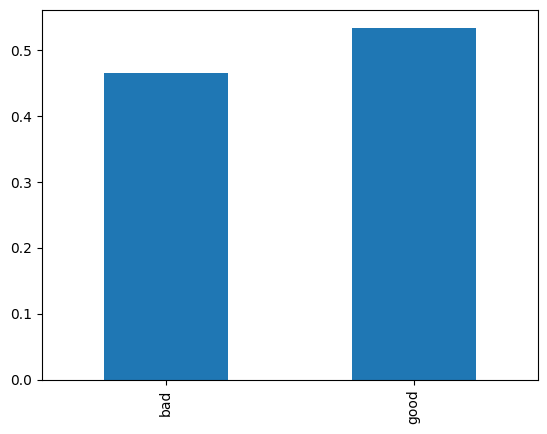

In [ ]:
wine_quality = df.label.value_counts(normalize=True)
wine_quality[["bad", "good"]].plot(kind="bar")
wine_quality

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
adult = pd.read_csv(url, names=column_names)

In [ ]:
# Drop rows with missing values
adult = adult.dropna()
len(adult)

32561

In [ ]:
# Convert categorical variables to numerical using LabelEncoder
label_encoders = {}
for column in adult.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    adult[column] = label_encoders[column].fit_transform(adult[column])

'''
# Separate features and target variable
X = adult.drop("income", axis=1).values
y = adult["income"].values
'''
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [ ]:
len(adult)

32561

## Random forest

In [ ]:
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]

    return df_bootstrapped

def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth)
        forest.append(tree)

    return forest

def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]

    return random_forest_predictions

In [ ]:
# Define a list of values for n_trees and n_features
n_trees_values = [50, 100, 150]
n_features_values = [2, 3, 4]

# Iterate over each combination of n_trees and n_features
for n_trees in n_trees_values:
    for n_features in n_features_values:
        # Split the dataset into training and testing sets
        train_df, test_df = train_test_split(adult, test_size=0.2)

        # Train the random forest algorithm
        forest = random_forest_algorithm(train_df, n_trees=n_trees, n_bootstrap=300, n_features=n_features, dt_max_depth=None)

        # Make predictions on the testing set
        predictions = random_forest_predictions(test_df, forest)

        # Calculate accuracy
        accuracy = calculate_accuracy(predictions, test_df.income)

        # Print the output
        print("n_trees={}, n_features={}: Accuracy = {:.2f}%".format(n_trees, n_features, accuracy * 100))

n_trees=50, n_features=2: Accuracy = 84.08%
n_trees=50, n_features=3: Accuracy = 85.03%
n_trees=50, n_features=4: Accuracy = 84.02%
n_trees=100, n_features=2: Accuracy = 84.60%
n_trees=100, n_features=3: Accuracy = 84.43%
n_trees=100, n_features=4: Accuracy = 84.91%
n_trees=150, n_features=2: Accuracy = 84.39%
n_trees=150, n_features=3: Accuracy = 85.58%
n_trees=150, n_features=4: Accuracy = 84.31%
